### in this notebook we will see how we can validate a model while training

We'll use model.train(), model.eval() and with torch.no_grad() <br>
Another thing to consider is that the model returns a probability distribution. So how can we calculate the accuracy for such a model? Let's do this. We'll take the argmax of the predicted label, and see if they match. So if the true label has the second emotion in the vector (for instance happiness) with the highest value, and the prediction also has the second element in the vector with the highest value, we'll consider it a match

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [3]:
class FERdataset(Dataset):
    def __init__(self, path_fer2013csv, path_fer2013newcsv):
        self.fer2013 = pd.read_csv(path_fer2013csv)
        self.fer2013labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
        self.fer2013new = pd.read_csv(path_fer2013newcsv)
        self.fer2013newlabels = list(self.fer2013new.columns[2:11])
        
    def __getitem__(self, index):
        '''
        returns an image and its fer2013new label as tensors
        '''
        image = self.fer2013['pixels'].iloc[index]
        image = np.fromstring(image, sep=' ').reshape(48, 48)
        image = torch.tensor(image, dtype=torch.float32) / 255
        
        label = torch.tensor(self.fer2013new.iloc[index][2:11].values.astype('float32')) / 10
        
        return image, label
        
    def __len__(self):
        return self.fer2013.shape[0]

In [7]:
path_fer2013csv='../../../data/fer2013/fer2013.csv'
path_fer2013newcsv='../../../data/FERplus/fer2013new.csv'
dataset = FERdataset(path_fer2013csv, path_fer2013newcsv)

In [8]:
from torch.utils.data import random_split

In [9]:
traindataset, valdataset, testdataset = random_split(dataset, [int(0.6*len(dataset)), int(0.2*len(dataset)), len(dataset) - (int(0.6*len(dataset)) + int(0.2*len(dataset)))], generator=torch.Generator().manual_seed(42))

In [10]:
print(f'traindataset length: {len(traindataset)}')
print(f'valdataset length: {len(valdataset)}')
print(f'testdataset length: {len(testdataset)}')

traindataset length: 21532
valdataset length: 7177
testdataset length: 7178


### let's create a sample model

We'll include batch normalization and dropout.

In [116]:
class Model1a(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.conv2 = nn.Conv2d(10, 10, 3)
        
        self.bn1 = nn.BatchNorm2d(10)
        self.bn2 = nn.BatchNorm2d(10)
        
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(10 * 22 * 22, len(dataset.fer2013newlabels))
        

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = torch.softmax(self.fc1(x), dim=1)

        return x

In [117]:
model1a = Model1a()
model1a

Model1a(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4840, out_features=9, bias=True)
)

In [118]:
# parameters
epochs = 5
batch_size = 100

In [119]:
trainloader = DataLoader(traindataset, batch_size, shuffle=True)
valloader = DataLoader(valdataset, batch_size, shuffle=True)

In [120]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1a.parameters())

In [121]:
running_loss = []
running_val_loss = []
print_every = 20
for e in range(1):
    for i,(images, labels) in enumerate(trainloader):
        model1a.train()
        images.unsqueeze_(1)
        if torch.cuda.is_available():
            images = images.to(torch.device('cuda'))
            labels = labels.to(torch.device('cuda'))

        optimizer.zero_grad()
        output = model1a(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()


        running_loss.append(loss.item())
        if i%print_every == 0:
            model1a.eval()
            with torch.no_grad():
                for j,(valimages, vallabels) in enumerate(valloader):
                    val_loss_list = []
                    valimages.unsqueeze_(1)
                    
                    val_output = model1a(valimages)
                    val_loss = criterion(val_output, vallabels)

                    val_loss_list.append(val_loss.item())

                val_loss_avg = sum(val_loss_list) / len(val_loss_list)

            running_val_loss.append(val_loss_avg)
            print(f'epoch: {e}, iteration: {i}, loss: {loss.item()}, val_loss: {val_loss_avg}')

epoch: 0, iteration: 0, loss: 2.1761553287506104, val_loss: 2.1489994525909424
epoch: 0, iteration: 20, loss: 1.9710644483566284, val_loss: 2.020648717880249
epoch: 0, iteration: 40, loss: 2.0415923595428467, val_loss: 1.9909683465957642
epoch: 0, iteration: 60, loss: 1.9724926948547363, val_loss: 1.9394041299819946
epoch: 0, iteration: 80, loss: 1.949426531791687, val_loss: 1.9177725315093994
epoch: 0, iteration: 100, loss: 1.949497938156128, val_loss: 1.9848109483718872
epoch: 0, iteration: 120, loss: 1.9172080755233765, val_loss: 1.908027172088623
epoch: 0, iteration: 140, loss: 1.9313499927520752, val_loss: 1.906486988067627
epoch: 0, iteration: 160, loss: 1.9353735446929932, val_loss: 1.914872407913208
epoch: 0, iteration: 180, loss: 1.907029390335083, val_loss: 1.9185000658035278
epoch: 0, iteration: 200, loss: 1.9359233379364014, val_loss: 1.9175260066986084


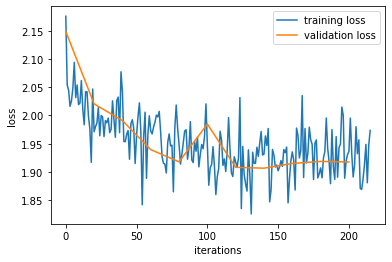

In [122]:
plt.plot(np.arange(len(running_loss)), running_loss, label='training loss')
plt.plot(np.arange(len(running_val_loss))*print_every, running_val_loss, label='validation loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()
plt.show()

### create logic to get the accuracy of the model

In [44]:
tloader = DataLoader(testdataset, 2, shuffle=True)

In [45]:
sample_images, sample_labels = next(iter(tloader))

In [46]:
sample_images.unsqueeze_(1)

tensor([[[[0.0314, 0.0431, 0.0627,  ..., 0.0784, 0.0745, 0.0784],
          [0.0392, 0.0471, 0.0706,  ..., 0.0824, 0.0784, 0.0784],
          [0.0431, 0.0549, 0.0745,  ..., 0.0824, 0.0784, 0.0784],
          ...,
          [0.5294, 0.4549, 0.3686,  ..., 0.1843, 0.1569, 0.1333],
          [0.3294, 0.4510, 0.3725,  ..., 0.1843, 0.1608, 0.1373],
          [0.2784, 0.4353, 0.3804,  ..., 0.1843, 0.1608, 0.1412]]],


        [[[0.1490, 0.1686, 0.1608,  ..., 1.0000, 1.0000, 1.0000],
          [0.1843, 0.1490, 0.1294,  ..., 1.0000, 1.0000, 1.0000],
          [0.1373, 0.1333, 0.1333,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.0824, 0.1137, 0.1686,  ..., 0.3176, 0.2588, 0.2353],
          [0.0784, 0.1255, 0.1529,  ..., 0.3529, 0.2941, 0.2549],
          [0.0784, 0.1451, 0.1451,  ..., 0.3804, 0.3255, 0.2980]]]])

In [47]:
sample_images.shape

torch.Size([2, 1, 48, 48])

In [48]:
sample_images[0].shape

torch.Size([1, 48, 48])

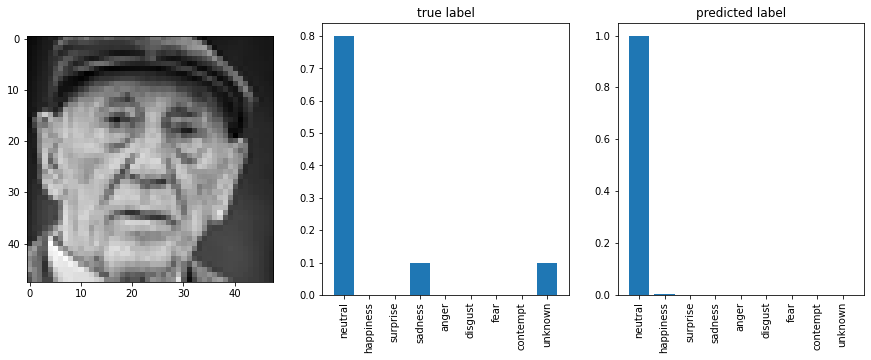

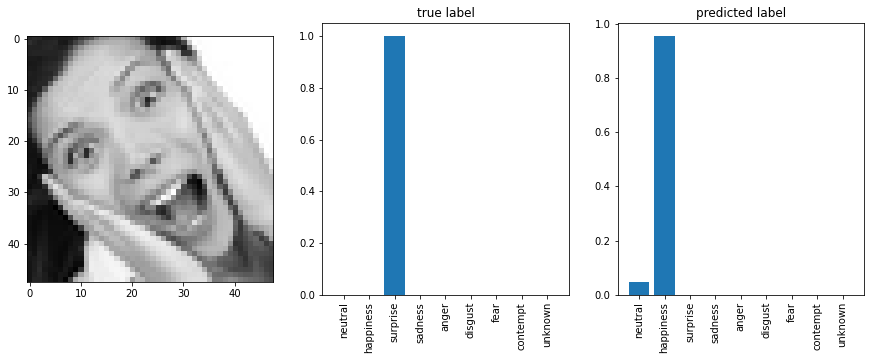

In [49]:
for i in range(2):
    prediction = model1a(sample_images)
    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(131)
    plt.imshow(sample_images.cpu()[i][0], cmap='gray')
    fig.add_subplot(132)
    plt.bar(dataset.fer2013newlabels, sample_labels[i])
    plt.xticks(rotation=90)
    plt.title('true label')
    fig.add_subplot(133)
    plt.bar(dataset.fer2013newlabels, prediction[i].cpu().detach().numpy())
    plt.xticks(rotation=90)
    plt.title('predicted label')

In [50]:
sample_labels

tensor([[0.8000, 0.0000, 0.0000, 0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

In [62]:
truelabels = torch.argmax(sample_labels, dim=1)
truelabels

tensor([0, 2])

In [83]:
truelabels.shape

torch.Size([2])

we can see that the true labels (maximum value in the labels) for the 2 sample images correspond to indices 0 and 2 

In [54]:
prediction

tensor([[9.9785e-01, 2.1509e-03, 2.4637e-14, 6.0130e-12, 4.1900e-12, 1.8083e-15,
         9.0534e-17, 2.3163e-16, 5.6898e-16],
        [4.5958e-02, 9.5404e-01, 2.0268e-13, 1.2632e-11, 2.7541e-11, 3.9209e-15,
         7.9946e-16, 1.8201e-15, 1.8417e-15]], grad_fn=<SoftmaxBackward0>)

In [63]:
predlabels = torch.argmax(prediction, dim=1)
predlabels

tensor([0, 1])

and that the predicted labels correspond to the indices 0 and 1

### Let's calculate the accuracy and a confusion matrix

In [57]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [96]:
accuracy_score(truelabels, predlabels)

0.7

In [82]:
truelabels.detach().numpy().shape

(2,)

In [64]:
confmat = confusion_matrix(truelabels.detach().numpy(), predlabels.detach().numpy())

In [65]:
confmat

array([[1, 0, 0],
       [0, 0, 0],
       [0, 1, 0]])

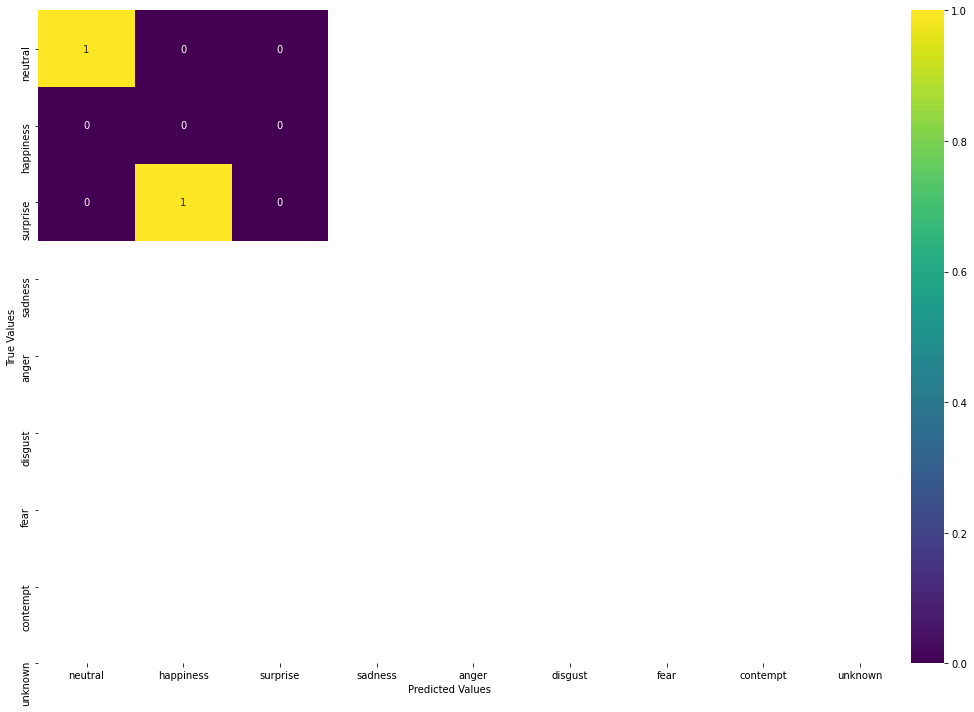

In [67]:
plt.figure(figsize=(15,10))
sns.heatmap(confmat, annot=True, fmt='.0f', cmap='viridis', xticklabels=dataset.fer2013newlabels, yticklabels=dataset.fer2013newlabels)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.tight_layout()
plt.show()

### inference

We can see that the true values for the 2 images respectively were neutral and surprise. But the predicted values were neutral and happiness.

The logic seems to work. let's implement it in the training loop. one thing to keep in mind is that the true labels and the predictions return a tensor for each batch. we are looking for a list or array that has the true and predicted labels for all the batches

### contatenating numpy arrays

lets see how we can concatenate numpy arrays to get the output in the form we want. we'll assume a batch size of 5. these true labels and predictions correspond to the argmax of the labels and predictions per batch

In [73]:
iter1_truelabels = np.array([0,1,4,2,3])
iter1_prediction = np.array([0,1,3,2,3])

In [74]:
iter1_truelabels

array([0, 1, 4, 2, 3])

In [75]:
iter1_prediction

array([0, 1, 3, 2, 3])

In [76]:
iter2_truelabels = np.array([3,4,2,0,1])
iter2_prediction = np.array([1,4,2,0,0])

In [77]:
iter2_truelabels

array([3, 4, 2, 0, 1])

In [78]:
iter2_prediction

array([1, 4, 2, 0, 0])

In [80]:
iter1_truelabels.shape

(5,)

now concatenate the true labels and the predictions to get one array each

In [87]:
truelabels = np.concatenate((iter1_truelabels, iter2_truelabels))
truelabels

array([0, 1, 4, 2, 3, 3, 4, 2, 0, 1])

In [88]:
predlabels = np.concatenate((iter1_prediction, iter2_prediction))
predlabels

array([0, 1, 3, 2, 3, 1, 4, 2, 0, 0])

nice. that was easy :)

One more thing. Let's see how to initialize an empty array so that can be used for concatenation if required. (in case we need the accuracy on the whole model, while running it in batches)

In [91]:
arr_empty = np.empty((0,))
arr_empty

array([], dtype=float64)

In [92]:
arr_empty.shape

(0,)

In [93]:
arr_notempty = np.array([1,2,3])
arr_notempty

array([1, 2, 3])

In [94]:
arr_notempty.shape

(3,)

In [95]:
arr_concat = np.concatenate((arr_empty, arr_notempty))
arr_concat

array([1., 2., 3.])

Okay. seems to work. lets move on to the next step

### implement validation logic in the training loop

In [141]:
model1a = Model1a()
model1a

Model1a(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4840, out_features=9, bias=True)
)

In [142]:
# parameters
epochs = 5
batch_size = 100

In [143]:
trainloader = DataLoader(traindataset, batch_size, shuffle=True)
valloader = DataLoader(valdataset, batch_size, shuffle=True)

In [144]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1a.parameters())

In [148]:
running_loss = []
running_val_loss = []
alltrainacc = []
allvalacc = []

print_every = 20
for e in range(1):
    for i,(images, labels) in enumerate(trainloader):
        model1a.train()
        images.unsqueeze_(1)
        if torch.cuda.is_available():
            images = images.to(torch.device('cuda'))
            labels = labels.to(torch.device('cuda'))

        optimizer.zero_grad()
        output = model1a(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())
        
        if i%print_every == 0:
            model1a.eval()
            with torch.no_grad():
                for j,(valimages, vallabels) in enumerate(valloader):
                    val_loss_list = []
                    valimages.unsqueeze_(1)
                    
                    val_output = model1a(valimages)
                    val_loss = criterion(val_output, vallabels)

                    val_loss_list.append(val_loss.item())
                    
                    # to calculate training accuracy
                    trueargmax = torch.argmax(labels, dim=1)
                    truelabels = trueargmax.detach().numpy()
                    predargmax = torch.argmax(output, dim=1)
                    predlabels = predargmax.detach().numpy()
                    
                    # to calculate validation accuracy
                    valtrueargmax = torch.argmax(vallabels, dim=1)
                    valtruelabels = valtrueargmax.detach().numpy()
                    valpredargmax = torch.argmax(val_output, dim=1)
                    valpredlabels = valpredargmax.detach().numpy()                    

                val_loss_avg = sum(val_loss_list) / len(val_loss_list)
                
            # calculate training and validation accuracy
            batchtrainacc = accuracy_score(truelabels, predlabels)
            batchvalacc = accuracy_score(valtruelabels, valpredlabels)
            
            # store the training and validation accuracies 
            alltrainacc.append(batchtrainacc)
            allvalacc.append(batchvalacc)

            running_val_loss.append(val_loss_avg)
            print(f'epoch: {e}, iteration: {i}, loss: {loss.item():.5f}, val_loss: {val_loss_avg:.5f}, acc: {batchtrainacc:.5f}, val_acc: {batchvalacc:.5f}')

epoch: 0, iteration: 0, loss: 2.04671, val_loss: 2.11234, acc: 0.32000, val_acc: 0.32468
epoch: 0, iteration: 20, loss: 1.98099, val_loss: 2.01885, acc: 0.49000, val_acc: 0.44156
epoch: 0, iteration: 40, loss: 1.89581, val_loss: 1.99715, acc: 0.56000, val_acc: 0.41558
epoch: 0, iteration: 60, loss: 1.93569, val_loss: 1.97543, acc: 0.50000, val_acc: 0.46753
epoch: 0, iteration: 80, loss: 1.99126, val_loss: 1.93129, acc: 0.42000, val_acc: 0.51948
epoch: 0, iteration: 100, loss: 1.87555, val_loss: 1.88791, acc: 0.54000, val_acc: 0.54545
epoch: 0, iteration: 120, loss: 1.94534, val_loss: 1.94581, acc: 0.48000, val_acc: 0.44156
epoch: 0, iteration: 140, loss: 1.96501, val_loss: 1.86414, acc: 0.46000, val_acc: 0.58442
epoch: 0, iteration: 160, loss: 1.91766, val_loss: 1.95241, acc: 0.46000, val_acc: 0.48052
epoch: 0, iteration: 180, loss: 1.99085, val_loss: 1.95264, acc: 0.47000, val_acc: 0.48052
epoch: 0, iteration: 200, loss: 1.92062, val_loss: 1.90404, acc: 0.48000, val_acc: 0.53247


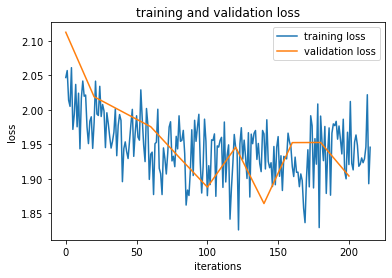

In [151]:
plt.plot(np.arange(len(running_loss)), running_loss, label='training loss')
plt.plot(np.arange(len(running_val_loss))*print_every, running_val_loss, label='validation loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

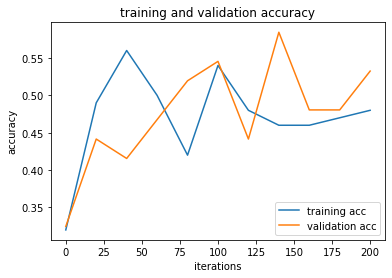

In [152]:
plt.plot(np.arange(len(alltrainacc))*print_every, alltrainacc, label='training acc')
plt.plot(np.arange(len(allvalacc))*print_every, allvalacc, label='validation acc')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('training and validation accuracy')
plt.legend()
plt.show()

### inference

considering the simplicity of the model, the performance is not all that bad. if the guess was absolutely random, we'd get an accuracy of 1/9 ~= 0.11111. so not terrible

### let's run some random tests

In [153]:
truelabels.shape

(100,)

In [154]:
truelabels

array([1, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1, 3, 0, 2, 2, 2, 1, 4, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 4, 0, 1, 0, 2, 0, 0, 0, 4, 0, 0, 4, 0, 6, 0, 0,
       0, 4, 2, 2, 0, 2, 0, 0, 2, 2, 4, 0, 3, 1, 2, 2, 1, 0, 6, 4, 1, 0,
       0, 3, 2, 3, 4, 1, 0, 1, 0, 0, 0, 0, 3, 4, 0, 0, 1, 0, 0, 3, 0, 3,
       3, 3, 2, 1, 3, 1, 2, 2, 1, 0, 0, 3])

In [155]:
predlabels.shape

(100,)

In [156]:
predlabels

array([1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0])

In [157]:
valtruelabels.shape

(77,)

In [158]:
valtruelabels

array([0, 1, 0, 1, 0, 1, 4, 1, 0, 4, 0, 1, 3, 6, 2, 0, 4, 2, 2, 6, 0, 0,
       2, 1, 3, 0, 1, 3, 8, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 4, 0,
       6, 4, 0, 1, 1, 1, 1, 1, 0, 1, 0, 3, 1, 0, 0, 0, 4, 0, 3, 1, 4, 0,
       1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 2])

In [159]:
valpredlabels.shape

(77,)

In [160]:
valpredlabels

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0])

In [161]:
valconfmat = confusion_matrix(valtruelabels, valpredlabels)

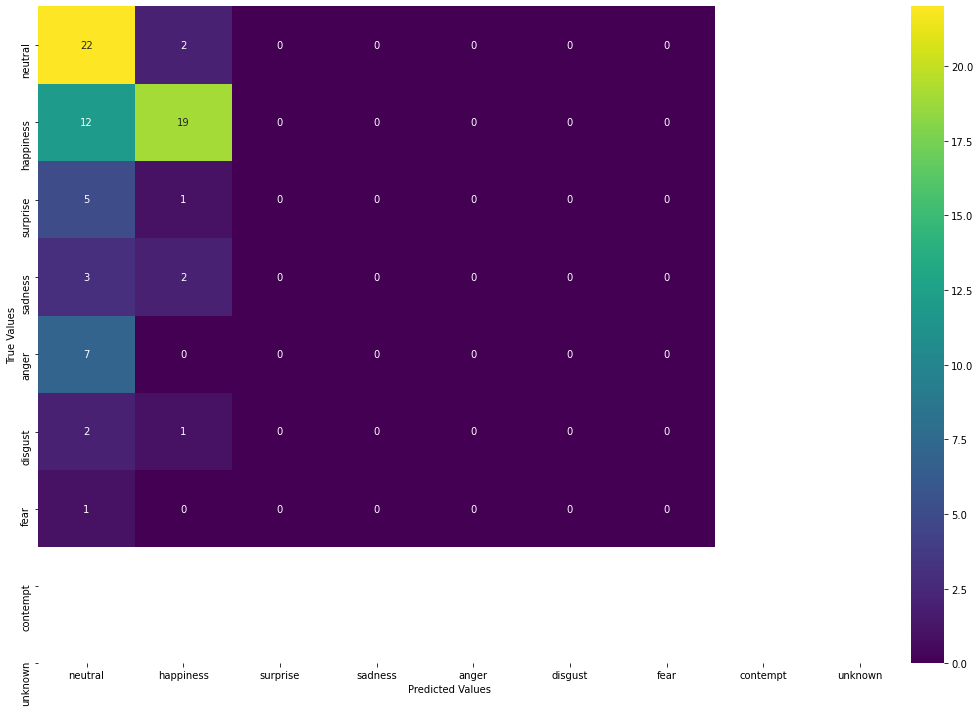

In [162]:
plt.figure(figsize=(15,10))
sns.heatmap(valconfmat, annot=True, fmt='.0f', cmap='viridis', xticklabels=dataset.fer2013newlabels, yticklabels=dataset.fer2013newlabels)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.tight_layout()
plt.show()

### inference

as we noticed before, the model has a huge propensity to predict 'happiness' or 'neutral'. in the example above, it doesnt even predict anything else. but this is a simple model and this behavior is more or less expected. we'll look at better models next